| 주차 | 일정                               | 페이지                                  |
|-----:|-----------------------------------|----------------------------------------|
|    1 | 1장-헬로 파이썬                     | 0p ~ 45p                               |
|    2 | 2장-퍼셉트론                        | 46p ~ 62p                              |
|    3 | 3장-신경망                          | 63p ~ 105p                             |
|    4 | 4장-신경망 학습                     | 106p ~ 146p                            |
|    5 | 5장-오차역전파법                    | 147p ~ 187p (+ Appendix A, 292p ~ 299p) |
|    6 | 중간고사(전)                        |                                        |
|    7 | 중간고사                           |                                        |
|    8 | 6장-학습 관련 기술들               | 188p ~ 226p                            |
|    9 | 7장-합성곱 신경망(CNN)             | 227p ~ 259p                            |
|   10 | 딥러닝                             | 261p ~ 308p                            |
|   11 | 1장-신경망 복습                    | 0p ~ 74p (+ Appendix A, 389p ~ 394p)  |
|   12 | 2장-자연어와 단어의 분산 표현      | 78p ~ 113p (+ Appendix B, 395p ~ 399p) |
|   13 | 기말고사(전)                       |                                        |
|   14 | 기말고사                          |                                        |
|   15 | 3장-word2vec                       | 114p ~ 147p                            |
|   16 | 4장-word2vec 속도 개선             | 148p ~ 189p                            |
|   17 | 5장-순환신경망(RNN)                | 190p ~ 235p                            |
|   18 | 6장-게이트가 추가된 RNN            | 263p ~ 286p (+ Appendix C, 401p ~ 402p)|
|   19 | 7장-RNN을 사용한 문장 생성         | 287p ~ 333p                            |
|   20 | 8장-어텐션                         | 334p ~ 387p                            |

# 18주차

게이트가 추가된 RNN

_237p ~ 286p_ (+ Appendix C, 401p ~ 402p)

---

## 6-1

전에 본 기본 RNN은 순환 경로를 통해 과거 정보를 저장할 수 있지만 구조가 단순한 기본 RNN이 시계열 데이터에서 장기 의존 관계를 잘 학습하지 못해 성능이 떨어진다는 문제가 있다. 이를 해결하기 위해 내부에 게이트 구조를 추가한 LSTM(Long short-term memory)과 GRU(Gated recurrent unit) 계층이 등장을 했는데 이를 통해 장/단기 기억을 구성할 수 있다.

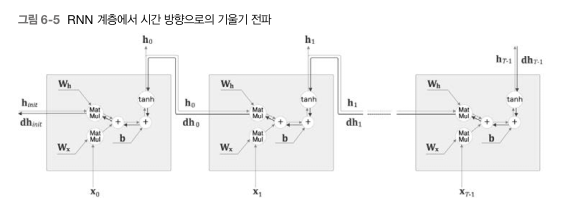

전에 다룬 BPTT(backprop though time)를 보면 덧셈 연산은 상류 기울기를 그대로 전달하는 반면 tanh 함수의 미분값은 항상 0과 1 사이에 머무르고, MatMul(행렬 곱) 연산은 가중치 행렬의 크기에 따라 기울기를 축소하거나 확대하므로 여러 시점에 걸친 연속 곱셈 과정에서 기울기가 급격히 작아지거나 커져 RNN이 장기 의존 관계를 학습하지 못하는 기울기 소실 및 폭발 현상이 발생하게 된다.

길이가 $T$인 시계열에서 역전파되는 기울기가 어떻게 변화하는지를 그림 6‑5를 수식을 통해 보면, 순전파가 은닉 상태와 입력에 대해

$$
\mathbf{h}_t = \tanh\bigl(\mathbf{W}_h \mathbf{h}_{t-1} + \mathbf{W}_x \mathbf{x}_t + \mathbf{b}\bigr)
$$

로 이루어지는 반면, 역전파 시에는 덧셈 연산이 기울기를 그대로 전달하고 tanh의 미분

$$
\frac{d}{dx}\tanh(x) = 1 - \tanh^2(x)
$$

값이 $(0,1)$ 사이에 머무르며, 행렬 곱 연산은 $\mathbf{W}_h$ 크기에 따라 기울기를 축소하거나 확대합니다. 이로 인해 여러 시점에 걸친 연속 곱셈 과정
$\prod_{i=1}^T \mathbf{W}_h$
에서 기울기가 점차 소실되거나 폭발하여 RNN이 장기 의존 관계를 학습하지 못하게 된다.

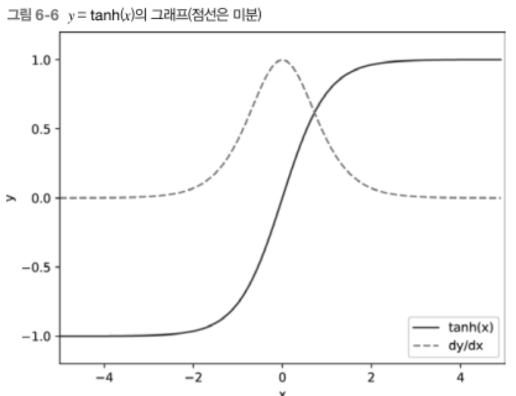

그림 6‑6은 활성화 함수 $y=\tanh(x)$의 그래프(실선)와 그 도함수

$$
\frac{d}{dx}\tanh(x)=1-\tanh^2(x)
$$

(점선)을 함께 보여주는데, $\tanh$의 기울기 값이 항상 1 이하이고 $x$가 0에서 멀어질수록 점차 0에 수렴함을 볼 수 있다. 따라서 역전파 과정에서 tanh 노드를 지날 때마다 전파되는 기울기가 입력의 절댓값이 커질수록 계속 작아져, **여러 시점에 걸친 곱셈을 반복하면 기울기가 거의 사라져 버린다. 이 때문에 기본 RNN은 장기 의존 관계를 효율적으로 학습하지 못하는 근본적 한계가 있음.**

MatMul의 기울기 소실/폭팔을 살펴보면, MatMul 노드에서의 기울기 전파가

$$
\mathrm{d}h_{t-1} = \mathrm{d}h_t\,W_h^{\mathsf T}
$$

로 계산되며, 같은 가중치 행렬 $W_h$가 매번 곱해지는 상황에서 시간축을 따라 반복될 때 기울기가 어떻게 변화하는지를 관찰

미니배치 크기 $N$, 은닉 상태 차원 $H$, 시계열 길이 $T$를 설정

$\mathrm{d}h$를 $\mathbf{1}$로 초기화하고 매 반복마다
$\mathrm{d}h \leftarrow \mathrm{d}h\,W_h^{\mathsf T}$
연산을 수행한 뒤, 평균 L2 노름

$$
\frac{1}{N}\sqrt{\sum_{i,j}(\mathrm{d}h_{ij})^2}
$$

을 기록하여 기울기가 점차 소실되거나 폭발하는 현상을 직접 확인 ㄱㄴ


**기울기 폭팔**

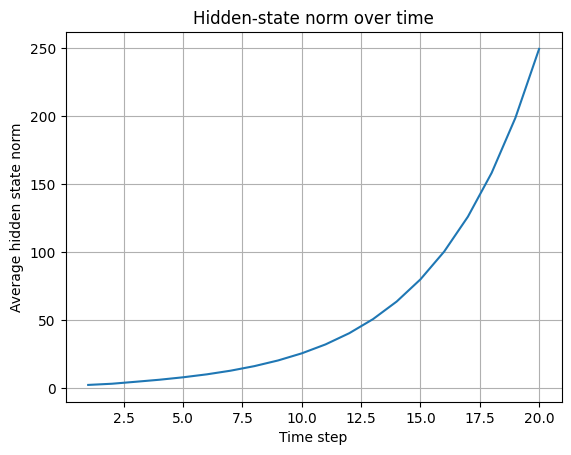

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 2       # mini-batch size
H = 3       # hidden state dimension
T = 20      # sequence length

# Initial hidden state
dh = np.ones((N, H))

# Weight matrix for hidden-to-hidden transition
np.random.seed(3)         # fix seed for reproducibility
Wh = np.random.randn(H, H)

# Collect average norms over time
norm_list = []
for t in range(T):
    dh = dh @ Wh.T
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

# Plot
plt.plot(range(1, T+1), norm_list)
plt.xlabel('Time step')
plt.ylabel('Average hidden state norm')
plt.title('Hidden-state norm over time')
plt.grid(True)
plt.show()


**기울기 소실**

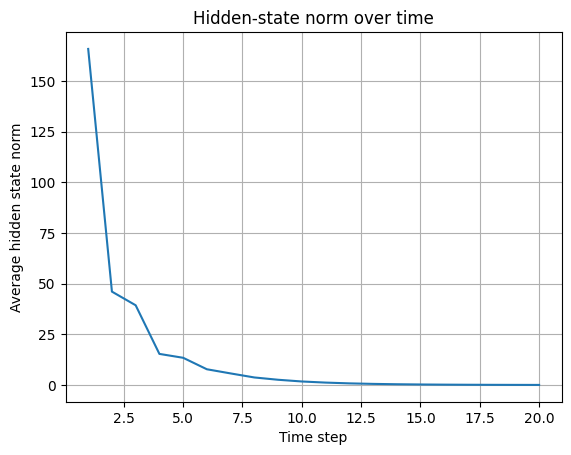

In [2]:
Wh = np.random.randn(H, H) * .5  # 여기 변경!

# Collect average norms over time
norm_list = []
for t in range(T):
    dh = dh @ Wh.T
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

# Plot
plt.plot(range(1, T+1), norm_list)
plt.xlabel('Time step')
plt.ylabel('Average hidden state norm')
plt.title('Hidden-state norm over time')
plt.grid(True)
plt.show()


당연히 `Wh`를 지속적으로 곱하는거니 1미만이면 줄어들어 사라지고, 1보다 크면 폭팔하는걸 볼 수 있음.

### (6-1-4) 기울기 폭팔 대책

**기울기 클리핑**(gradient clipping) 기법을 사용! 모든 매개변수에 대한 기울기를 하나의 벡터 $\mathbf{g}$로 모아 그 L2 노름 $\|\mathbf{g}\|$이 설정한 임계값(threshold) 이상일 때만 clipping(제한이랄까?)을 해버림

$$
\hat{\mathbf{g}} =
\begin{cases}
\displaystyle \mathbf{g}, & \|\mathbf{g}\| < \text{threshold},\\[1em]
\displaystyle \frac{\text{threshold}}{\|\mathbf{g}\|}\,\mathbf{g}, & \|\mathbf{g}\| \ge \text{threshold}.
\end{cases}
$$

이 과정을 거치면 과도하게 커진 기울기를 임계값 크기로 억제 ㄱㄴ

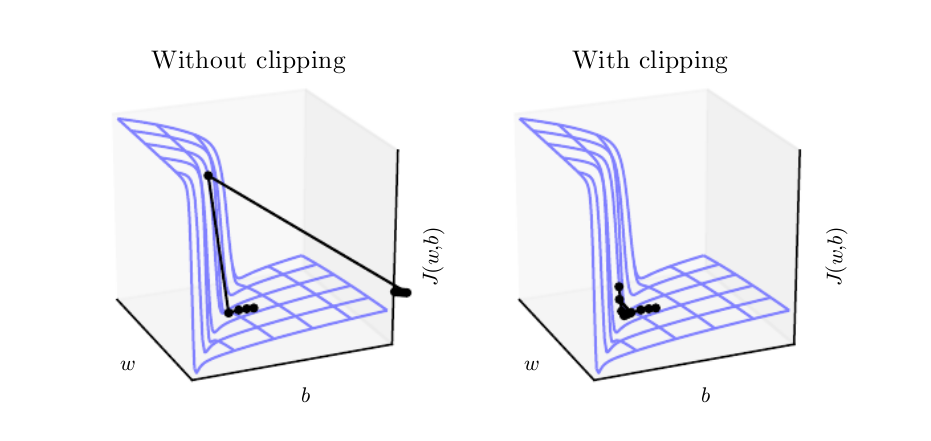
z축이 오류, z, y축이 weight, bias... 급경사(exposion), 평지(vanishing)부분에서 이상한 경사도 때문에 해매거나 overshoot해버리는거 막아줌

In [3]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

## 6-2 기울기 소실과 LSTM

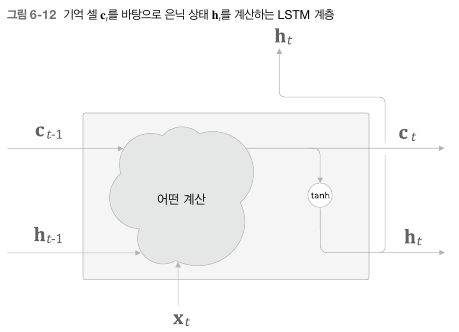

기존 RNN과 비교하면 $c_t$가 있다는 점, tanh를 거치지 않고 쌩으로 다음 cell로 넘어가고, 밖으로 출력하는 값이 아님 (cell끼리만 공유하는 "기억" 값)

소실을 일으키는 tanh를 안거치는 기억을 그대로 다음으로 넘기는 C값을 통해서 소실문제를 완화할 수 있음.

output gate같은 경우에는 다음 셀로 넘길 h값에다가 현 셀이 받은 x와 h값을 얼마나 넘길지를 판단한다. notation은 $\sigma$이고 계산은 아다마르 곱을 사용한다.

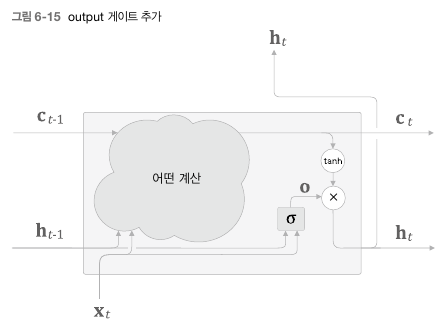

forget gate는 c에 대하여 x, h인풋에 대하여 얼마나 잊을지/제외시킬지를 정하는 게이트이다. 또, forget만 하면 c의 정보가 계속 깍겨나가므로(새 정보의 입력 없음) 더해주는 tanh input도 만들어준다(g). 이걸 다 합하면 다음과 같은 구조가 나온다.

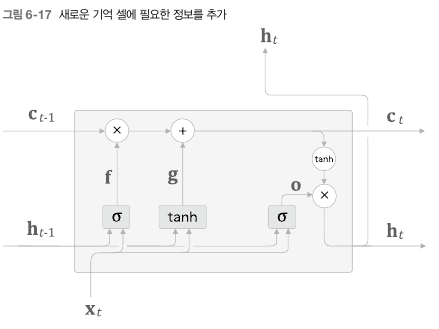

또, 추가로 tanh정규화 안거친 "생"정보 입력을 위한 게이트 또한 추가해준다.

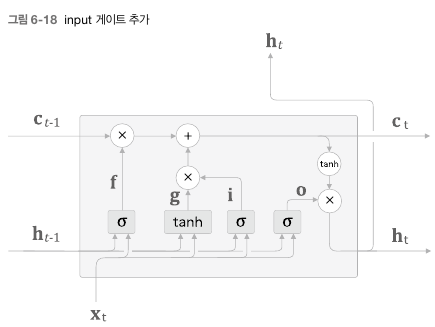

최종적인 구조는 다음과 같다:

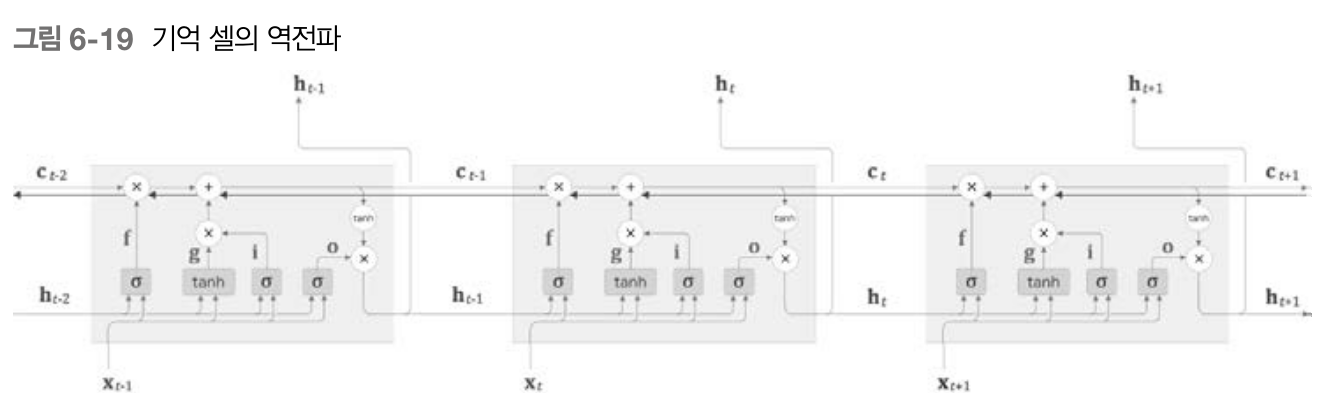

## 6-3 구현하기

코드로 구현을 하면 각 셀의 f, g, i, o계산은 한번의 행렬계산으로 진행을 한다.

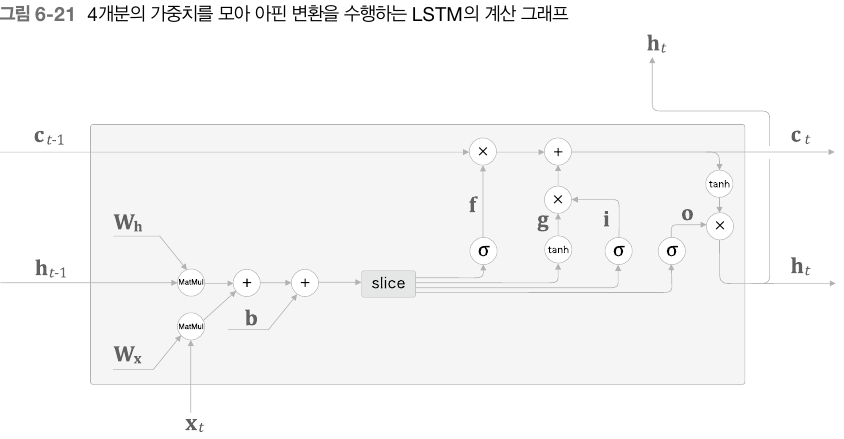

인풋들이 그래도 공통된 $W_h$, $W_x$, $b$를 쓰니까 가능한 일이다. 각 연산은 독립적이니 한방에 해도 문제 없다는 말!

In [4]:
from common.functions import sigmoid

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i  # Ct
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        
        dc_prev = ds * f
        
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)
        
        dA = np.hstack((df, dg, di, do))
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

`TimeLSTM` 구현은 위에서 구현한 각 LSTM들을 T개분의 시계열 데이터로 쭉 나열한 하나의 은닉층을 상징

앞서 RNN에서 했듯이 메모리 overload방지 위해 Truncated형태도 유지

In [5]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.99
| 에폭 1 |  반복 21 / 1327 | 시간 3[s] | 퍼플렉서티 2692.74
| 에폭 1 |  반복 41 / 1327 | 시간 5[s] | 퍼플렉서티 1216.06
| 에폭 1 |  반복 61 / 1327 | 시간 8[s] | 퍼플렉서티 955.26
| 에폭 1 |  반복 81 / 1327 | 시간 11[s] | 퍼플렉서티 779.83
| 에폭 1 |  반복 101 / 1327 | 시간 13[s] | 퍼플렉서티 655.26
| 에폭 1 |  반복 121 / 1327 | 시간 16[s] | 퍼플렉서티 635.58
| 에폭 1 |  반복 141 / 1327 | 시간 19[s] | 퍼플렉서티 617.00
| 에폭 1 |  반복 161 / 1327 | 시간 21[s] | 퍼플렉서티 563.44
| 에폭 1 |  반복 181 / 1327 | 시간 23[s] | 퍼플렉서티 578.63
| 에폭 1 |  반복 201 / 1327 | 시간 25[s] | 퍼플렉서티 513.19
| 에폭 1 |  반복 221 / 1327 | 시간 28[s] | 퍼플렉서티 496.50
| 에폭 1 |  반복 241 / 1327 | 시간 31[s] | 퍼플렉서티 442.72
| 에폭 1 |  반복 261 / 1327 | 시간 33[s] | 퍼플렉서티 463.99
| 에폭 1 |  반복 281 / 1327 | 시간 35[s] | 퍼플렉서티 449.58
| 에폭 1 |  반복 301 / 1327 | 시간 38[s] | 퍼플렉서티 385.43
| 에폭 1 |  반복 321 / 1327 | 시간 40[s] | 퍼플렉서티 346.16
| 에폭 1 |  반복 341 / 1327 | 시간 43[s] | 퍼플렉서티 400.09
| 에폭 1 |  반복 361 / 1327 | 시간 45[s] | 퍼플렉서티 403.90
| 에폭 1 |  반복 381 / 1327 | 시간 50[s] | 퍼플렉서티 327.49
| 에폭 1

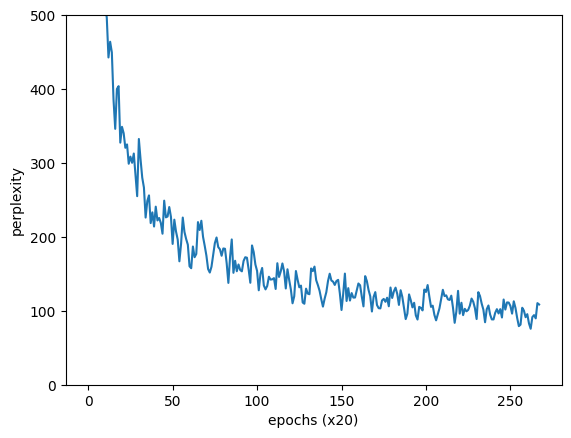

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  134.44312954847604


In [7]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

`Rnnlm`은 전 장에서 한 `SimpleRnnlm`에서 단순 RNN셀이 아니라 LSTM셀을 사용한거!

In [6]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()